In [1]:
from matplotlib import colors
import matplotlib.pyplot as plt
import numpy as np
from misc import normalization
import tensorflow as tf
import pandas as pd
from material_models_fig_synth_val import GOH_fullyinc
fsize=5
pltparams = {'legend.fontsize': 'large',
          'figure.figsize': (fsize*4,fsize),
          'font.size'     : 3*fsize,
          "mathtext.fontset": 'dejavuserif',
          }
plt.rcParams.update(pltparams)
cmap = plt.cm.get_cmap('inferno_r', 256)
cmap = colors.ListedColormap(cmap(np.linspace(0.1, 1, 256)))

#### Generate data

In [ ]:
ndp = 250
F = np.zeros((3*ndp,3,3))

# Validation set 1
lm1 = np.random.uniform(low = 1., high = 1.25, size = ndp)
lm2 = np.random.uniform(low = 1., high = 1.25, size = ndp)

F[:ndp, 0, 0] = lm1
F[:ndp, 1, 1] = lm2
F[:ndp, 2, 2] = 1/(lm1*lm2)

# Validation set 2
lm1 = np.random.uniform(low = 1., high = 1.25, size = ndp)
lm2 = np.random.uniform(low = 1., high = 1.25, size = ndp)
gamma12 = np.random.uniform(low = 0, high = 0.3, size = ndp)

F[ndp:2*ndp, 0, 0] = lm1
F[ndp:2*ndp, 1, 1] = lm2
F[ndp:2*ndp, 0, 1] = gamma12
F[ndp:2*ndp, 1, 0] = gamma12
F[ndp:2*ndp, 2, 2] = 1/(lm1*lm2 - gamma12**2)

# Validation set 3 part 1
size = int(ndp/3)
lm1 = np.random.uniform(low = 1.25, high = 1.35, size = size)
lm2 = np.random.uniform(low = 1., high = 1.25, size = size)
F[2*ndp:2*ndp+size, 0, 0] = lm1
F[2*ndp:2*ndp+size, 1, 1] = lm2
F[2*ndp:2*ndp+size, 2, 2] = 1/(lm1*lm2)

lm1 = np.random.uniform(low = 1., high = 1.25, size = size)
lm2 = np.random.uniform(low = 1.25, high = 1.35, size = size)
F[2*ndp+size:2*ndp+2*size, 0, 0] = lm1
F[2*ndp+size:2*ndp+2*size, 1, 1] = lm2
F[2*ndp+size:2*ndp+2*size, 2, 2] = 1/(lm1*lm2)

lm1 = np.random.uniform(low = 1.25, high = 1.35, size = ndp-2*size)
lm2 = np.random.uniform(low = 1.25, high = 1.35, size = ndp-2*size)
F[2*ndp+2*size:3*ndp, 0, 0] = lm1
F[2*ndp+2*size:3*ndp, 1, 1] = lm2
F[2*ndp+2*size:3*ndp, 2, 2] = 1/(lm1*lm2)

GOH_params = [9.86876414e-04, 5.64353050e-01, 7.95242698e+01, 2.94747207e-01, 1.57079633e+00]
GOH = GOH_fullyinc(F, GOH_params[0], GOH_params[1], GOH_params[2], GOH_params[3], GOH_params[4])
sigma = GOH.s()

with open('training_data/val_dsets.npy','wb') as f:
    np.save(f,[F, sigma])

In [4]:
with open('training_data/val_dsets.npy', 'rb') as f:
    F, sigma_gt = np.load(f)
FT = np.transpose(F, axes=[0,2,1])

#Normalize the gt data
sigma_gt_mean = np.mean(sigma_gt, axis=0)
sigma_gt_stdv = np.std(sigma_gt, axis=0)

for i in range(sigma_gt.shape[0]):
    for j in range(3):
        for k in range(3):
            if sigma_gt_stdv[j,k] == 0:
                sigma_gt[i,j,k] = 0
            else:
                sigma_gt[i,j,k] = (sigma_gt[i,j,k]-sigma_gt_mean[j,k])/sigma_gt_stdv[j,k]

In [5]:
# Load the model, normalize inputs and make predictions

model_name = 'P1C1_s'
model_fname   = 'savednet/'+model_name+'.json'
weights_fname = 'savednet/'+model_name+'_weights.h5'
model = tf.keras.models.model_from_json(open(model_fname).read())
model.load_weights(weights_fname)

ndata = F.shape[0]
C = np.einsum('...ji,...jk->...ik', F, F)
C_inv = np.linalg.inv(C)
I1 = C.trace(axis1=1, axis2=2)
C2 = np.einsum("...ij,...jk->...ik", C, C)
I2 = 1/2*(I1**2 - np.trace(C2,axis1=1, axis2=2))
theta = 0
a0 = np.array([ np.cos(theta), np.sin(theta), 0])
s0 = np.array([-np.sin(theta), np.cos(theta), 0])
a0a0 = np.outer(a0,a0)
s0s0 = np.outer(s0,s0)
I4a = np.einsum('i,pij,j->p',a0,C,a0)
I4s = np.einsum('i,pij,j->p',s0,C,s0)

Psi_gt = np.zeros_like(I1)
_, meanI1, meanI2, meanI4a, meanI4s, stdPsi, stdI1, stdI2, stdI4a, stdI4s = normalization(True, model_name, Psi_gt, I1, I2, I4a, I4s)

I4a = np.clip(I4a, a_min=1.0, a_max=None)
I4s = np.clip(I4s, a_min=1.0, a_max=None)
I1norm  = (I1  - meanI1) /stdI1
I2norm  = (I2  - meanI2) /stdI2
I4anorm = (I4a - meanI4a)/stdI4a
I4snorm = (I4s - meanI4s)/stdI4s

inputs = np.array([I1norm, I2norm, I4anorm, I4snorm]).transpose()

y_pred = model(inputs)
d1 = y_pred[:,1]**2*stdPsi/stdI1
d2 = y_pred[:,2]**2*stdPsi/stdI2
d3 = y_pred[:,3]**2*stdPsi/stdI4a
d4 = y_pred[:,4]**2*stdPsi/stdI4s

sigma_pr = np.zeros_like(C)
p = -(2*d1[:] + 2*d2[:]*(I1-C[:,2,2]))*C[:,2,2]
I1_2 = np.zeros_like(C)
for i in range(ndata):
    I1_2[i,:,:] = I1[i]*np.eye(3)
    sigma_pr[i,:,:] = 2*d1[i]*np.eye(3) + 2*d2[i]*(I1_2[i,:,:]-C[i,:,:]) 
    sigma_pr[i,:,:]+= 2*d3[i]*a0a0[:,:] + 2*d4[i]*s0s0[:,:] + p[i]*C_inv[i,:,:]
    sigma_pr[i] = np.matmul(F[i], np.matmul(sigma_pr[i], FT[i]))

In [6]:
#Normalize the pr data
for i in range(sigma_gt.shape[0]):
    for j in range(3):
        for k in range(3):
            if sigma_gt_stdv[j,k] == 0:
                sigma_pr[i,j,k] = 0
            else:
                sigma_pr[i,j,k] = (sigma_pr[i,j,k]-sigma_gt_mean[j,k])/sigma_gt_stdv[j,k]

In [7]:
# Error calculation
error = np.zeros(sigma_gt.shape[0])
dummy = np.zeros(sigma_gt.shape[0])
for i in range(sigma_gt.shape[0]):
    for j in range(3):
        for k in range(3):
            error[i]+= (sigma_gt[i,k,j] - sigma_pr[i,k,j])**2/9
            # dummy[i]+= sigma_gt[i,k,j]**2 
    error[i] = np.sqrt(error[i])
    dummy[i] = np.sqrt(dummy[i])
    # error[i] = error[i]/dummy[i]

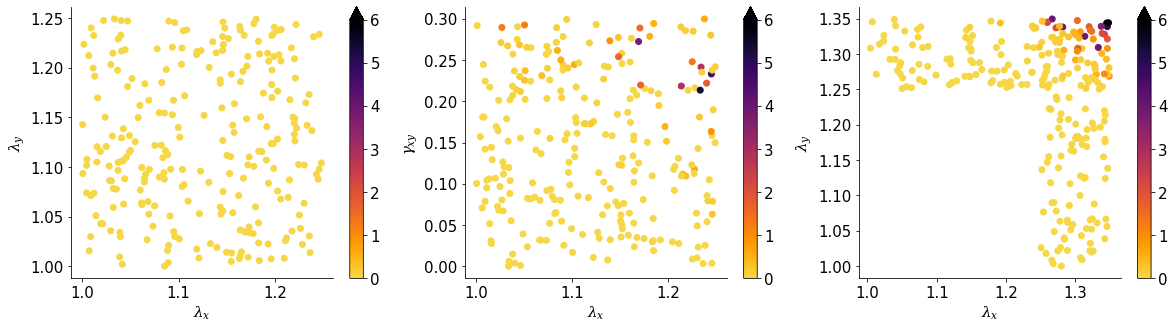

In [8]:
ndp = 250
fig = plt.figure()
gs = fig.add_gridspec(1,3, wspace=0.2, hspace=0.25) #nrows, ncols

ax1 = fig.add_subplot(gs[0, 0])
sctr1 = ax1.scatter(F[:ndp,0,0], F[:ndp,1,1], c= error[:ndp], cmap=cmap, vmin = 0, vmax = 6)
ax1.set(xlabel = '$\\lambda_x$', ylabel = '$\\lambda_y$')
cbar = fig.colorbar(sctr1, ax=ax1, extend='max')
# cbar.set_ticks([0, 25, 50, 75, 100])
# cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])

ax2 = fig.add_subplot(gs[0,1])
sctr2 = ax2.scatter(F[ndp:2*ndp,0,0], F[ndp:2*ndp,0,1], c=error[ndp:2*ndp], cmap=cmap, vmin=0, vmax = 6)
ax2.set(xlabel = '$\\lambda_x$', ylabel = '$\\gamma_{xy}$')
cbar = fig.colorbar(sctr2, ax=ax2, extend='max')
# cbar.set_ticks([0, 25, 50, 75, 100])
# cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])

#Right
ax3 = fig.add_subplot(gs[0, 2])
sctr3 = ax3.scatter(F[2*ndp:3*ndp,0,0], F[2*ndp:3*ndp,1,1], c= error[2*ndp:3*ndp], cmap=cmap, vmin = 0, vmax = 6)
ax3.set(xlabel = '$\\lambda_x$', ylabel = '$\\lambda_y$')
cbar = fig.colorbar(sctr3, ax=ax3, extend='max')
# cbar.set_ticks([0, 25, 50, 75, 100])
# cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])

axi =[ax1, ax2, ax3]
for ax in axi:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
fig.savefig('figs/fig_synthetic_val.jpg', bbox_inches='tight')

In [14]:
x = F[:ndp,0,0]
y = F[:ndp,1,1]
c = error[:ndp]
data = np.stack([x, y, c])
header = ['x', 'y', 'c']
df = pd.DataFrame(data.T, columns=header)
df.to_csv('tikz_data/fig_synthetic_val_data/fig_synthetic_val_A.csv', index=False, sep=' ')

In [15]:
x = F[ndp:2*ndp,0,0]
y = F[ndp:2*ndp,0,1]
c = error[ndp:2*ndp]
data = np.stack([x, y, c])
header = ['x', 'y', 'c']
df = pd.DataFrame(data.T, columns=header)
df.to_csv('tikz_data/fig_synthetic_val_data/fig_synthetic_val_B.csv', index=False, sep=' ')

In [16]:
x = F[2*ndp:3*ndp,0,0]
y = F[2*ndp:3*ndp,1,1]
c = error[2*ndp:3*ndp]
data = np.stack([x, y, c])
header = ['x', 'y', 'c']
df = pd.DataFrame(data.T, columns=header)
df.to_csv('tikz_data/fig_synthetic_val_data/fig_synthetic_val_C.csv', index=False, sep=' ')